# Part 1: Regression Analysis on Diamond Dataset

## Step 0: Import Libraries and Load Dataset

In [ ]:
!pip3 install seaborn
!pip3 install statsmodels

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_selection import mutual_info_regression
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge
import statsmodels.api as sm

In [3]:
# Read diamonds_ece219.csv

# Read the CSV file
df = pd.read_csv('diamonds_ece219.csv')
df = df.drop("Unnamed: 0", axis=1)
df.head()

,color,clarity,carat,cut,symmetry,polish,depth_percent,table_percent,length,width,depth,girdle_min,girdle_max,price
0,E,VVS2,0.09,Excellent,Very Good,Very Good,62.7,59.0,2.85,2.87,1.79,M,M,200
1,E,VVS2,0.09,Very Good,Very Good,Very Good,61.9,59.0,2.84,2.89,1.78,STK,STK,200
2,E,VVS2,0.09,Excellent,Very Good,Very Good,61.1,59.0,2.88,2.90,1.77,TN,M,200
3,E,VVS2,0.09,Excellent,Very Good,Very Good,62.0,59.0,2.86,2.88,1.78,M,STK,200
4,E,VVS2,0.09,Very Good,Very Good,Excellent,64.9,58.5,2.79,2.83,1.82,STK,STK,200


In [4]:
# print the column names
print(df.columns)

Index(['color', 'clarity', 'carat', 'cut', 'symmetry', 'polish',
       'depth_percent', 'table_percent', 'length', 'width', 'depth',
       'girdle_min', 'girdle_max', 'price'],
      dtype='object')


## Step 1: Exploratory Data Analysis & Feature Engineering

### 1.1) Handling Categorical Features

**One-Hot Encoding**

**Example:**
- Original feature: "Color" with values ["Red", "Blue", "Green"]
- One-hot encoded:
  - Color_Red: [1, 0, 0]
  - Color_Blue: [0, 1, 0] 
  - Color_Green: [0, 0, 1]

**When to use:** Best for nominal categories with no inherent order and relatively few unique values.

**Label Encoding**

**Example:**
- Original feature: "Size" with values ["Small", "Medium", "Large"]
- Label encoded: [0, 1, 2]

**When to use:** Appropriate for ordinal data where order matters, or as input to tree-based models.

**Target Encoding**

**Example:**
- Feature: "Neighborhood" with values ["Downtown", "Suburbs", "Rural"]
- Target: House price (mean prices: Downtown=$500k, Suburbs=$350k, Rural=$250k)
- Target encoded: ["Downtown"→500000, "Suburbs"→350000, "Rural"→250000]

**When to use:** Helpful for high-cardinality features (many unique values) in regression problems.

**Frequency Encoding**

**Example:**
- Feature: "Customer Country" with 100 records: 50 USA, 30 Canada, 20 Mexico
- Frequency encoded: ["USA"→0.5, "Canada"→0.3, "Mexico"→0.2]

**When to use:** When the frequency of a category is likely predictive.

In [9]:
# figure out the categorical variables names and numerical variables names
cat_vars = df.select_dtypes(include=['object']).columns.tolist()
num_vars = df.select_dtypes(include=['int64', 'float64']).columns.tolist()  # target variable is price, which is a numerical variable

print(f"Categorical variables: {cat_vars}")
print(f"Numerical variables: {num_vars}")



Categorical variables: ['color', 'clarity', 'cut', 'symmetry', 'polish', 'girdle_min', 'girdle_max']
Numerical variables: ['carat', 'depth_percent', 'table_percent', 'length', 'width', 'depth', 'price']


In [29]:
# separate the categorical variables from the numerical variables
categorical = df[cat_vars]
numerical = df[num_vars]

In [12]:
# Analyze each categorical variable to determine encoding method
encoding_recommendations = {}

for column in categorical.columns:
    unique_values = categorical[column].unique()
    value_count = len(unique_values)
    
    # Print column info
    print(f"\n{column}:")
    print(f"  - Unique values ({value_count}): {sorted(unique_values)}")
    
    # Check for ordinal structure in common diamond attributes
    if column == 'color':
        # Diamond color grades are ordered from D (best) to Z (worst)
        recommendation = "Ordinal encoding - natural ordering from D (colorless) to Z (yellow)"
    elif column == 'clarity':
        # Clarity has natural ordering
        recommendation = "Ordinal encoding - natural ordering from highest clarity to lowest"
    elif column in ['cut', 'symmetry', 'polish']:
        # These typically have quality grades with natural ordering
        recommendation = "Ordinal encoding - natural ordering from highest to lowest quality"
    elif 'girdle' in column:
        # Girdle measurements have many categories without clear numerical relationship
        recommendation = "One-hot encoding - multiple categories without simple linear relationship"
    else:
        # Default recommendation based on cardinality
        if value_count <= 10:
            recommendation = "One-hot encoding - low cardinality"
        else:
            recommendation = "Consider ordinal encoding or dimension reduction techniques"
    
    encoding_recommendations[column] = recommendation
    print(f"  - Recommendation: {recommendation}")


color:
  - Unique values (10): ['D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M']
  - Recommendation: Ordinal encoding - natural ordering from D (colorless) to Z (yellow)

clarity:
  - Unique values (10): ['I1', 'I2', 'I3', 'IF', 'SI1', 'SI2', 'VS1', 'VS2', 'VVS1', 'VVS2']
  - Recommendation: Ordinal encoding - natural ordering from highest clarity to lowest

cut:
  - Unique values (2): ['Excellent', 'Very Good']
  - Recommendation: Ordinal encoding - natural ordering from highest to lowest quality

symmetry:
  - Unique values (2): ['Excellent', 'Very Good']
  - Recommendation: Ordinal encoding - natural ordering from highest to lowest quality

polish:
  - Unique values (2): ['Excellent', 'Very Good']
  - Recommendation: Ordinal encoding - natural ordering from highest to lowest quality

girdle_min:
  - Unique values (10): ['M', 'STK', 'STN', 'TK', 'TN', 'VTK', 'VTN', 'XTK', 'XTN', 'unknown']
  - Recommendation: One-hot encoding - multiple categories without simple linear relationship

In [15]:
# Apply encoding recommendations to categorical features
categorical_encoded = pd.DataFrame()

# 1. Ordinal encoding for features with natural ordering
# Color: D (colorless/best) to Z (yellow/worst)
color_order = ['D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
categorical_encoded['color'] = categorical['color'].map({color: i for i, color in enumerate(color_order)})

# Clarity: highest clarity to lowest
clarity_order = ['FL', 'IF', 'VVS1', 'VVS2', 'VS1', 'VS2', 'SI1', 'SI2', 'I1', 'I2', 'I3']
categorical_encoded['clarity'] = categorical['clarity'].map({clarity: i for i, clarity in enumerate(clarity_order)})

# Cut, Polish, Symmetry: highest to lowest quality
quality_order = ['Excellent', 'Very Good', 'Good', 'Fair', 'Poor']
categorical_encoded['cut'] = categorical['cut'].map({quality: i for i, quality in enumerate(quality_order)})
categorical_encoded['polish'] = categorical['polish'].map({quality: i for i, quality in enumerate(quality_order)})
categorical_encoded['symmetry'] = categorical['symmetry'].map({quality: i for i, quality in enumerate(quality_order)})

# 2. One-hot encoding for girdle_min and girdle_max
girdle_min_encoded = pd.get_dummies(categorical['girdle_min'], prefix='girdle_min')
girdle_max_encoded = pd.get_dummies(categorical['girdle_max'], prefix='girdle_max')

#  turn 'true' and 'false' to 1 and 0
girdle_min_encoded = girdle_min_encoded.astype(int)
girdle_max_encoded = girdle_max_encoded.astype(int)

# Concatenate label encoded features with one-hot encoded features
categorical_encoded = pd.concat([categorical_encoded, girdle_min_encoded, girdle_max_encoded], axis=1)

# Show the first few rows of the encoded dataframe
categorical_encoded.head()

,color,clarity,cut,polish,symmetry,girdle_min_M,girdle_min_STK,girdle_min_STN,girdle_min_TK,girdle_min_TN,...,girdle_max_M,girdle_max_STK,girdle_max_STN,girdle_max_TK,girdle_max_TN,girdle_max_VTK,girdle_max_VTN,girdle_max_XTK,girdle_max_XTN,girdle_max_unknown
0,1,3,0,1,1,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,1,3,1,1,1,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,1,3,0,1,1,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0
3,1,3,0,1,1,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,1,3,1,0,1,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0


Now, we have:
 1. numerical features 'numerical', with target varible 'price' in it
 2. original categorical features 'categorical' 
 3. encoded categorical features 'categorical_encoded', some via label encoding and other via one-hot encoding

### 1.2) Exploratory Data Analysis

#### 1.2.1 Numerical Features

- Pearson Correlation Matrix
- Histogram

##### Pearson Correlation Matrix

The Pearson correlation coefficient measures the linear relationship between two continuous variables, producing values between -1 (perfect negative correlation) and +1 (perfect positive correlation), with 0 indicating no linear relationship.

In [20]:
# calculate pearson correlation matrix for numerical features, round it to 2 decimal places
pearson_corr = numerical.corr(method='pearson').round(2)
pearson_corr


,carat,depth_percent,table_percent,length,width,depth,price
carat,1.00,0.03,0.02,0.97,0.94,0.34,0.91
depth_percent,0.03,1.00,0.73,0.02,0.02,0.02,0.03
table_percent,0.02,0.73,1.00,0.03,0.03,0.00,0.04
length,0.97,0.02,0.03,1.00,0.97,0.35,0.87
width,0.94,0.02,0.03,0.97,1.00,0.34,0.84
depth,0.34,0.02,0.00,0.35,0.34,1.00,0.30
price,0.91,0.03,0.04,0.87,0.84,0.30,1.00


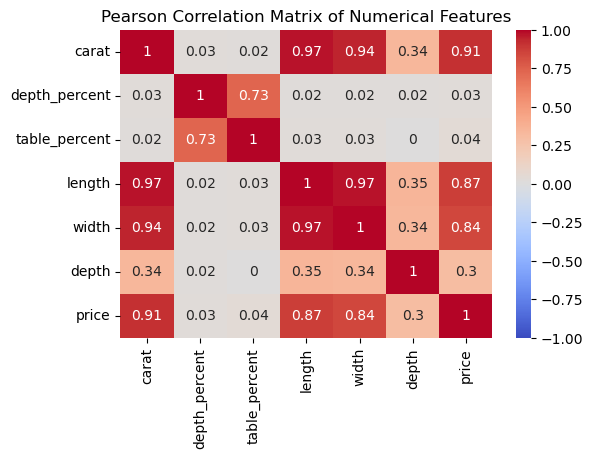

In [23]:
# plot a heatmap of the pearson correlation matrix, shrink it to 10x8
plt.figure(figsize=(6, 4))
sn.heatmap(pearson_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Pearson Correlation Matrix of Numerical Features')
plt.show()



**Question 1.1**: Report which features have the highest absolute correlation with the target variabledescribe what the correlation patterns suggest.

1. Strong Correlations with Price
- Carat: 0.91 - Extremely strong positive correlation with price, indicating that as the carat weight increases, the price increases substantially. This is the strongest predictor of price.
- Length: 0.87 - Very strong positive correlation with price.
- Width: 0.84 - Very strong positive correlation with price.

2. Multicollinearity Considerations
- Carat, Length, and Width: These three features are highly intercorrelated (0.94-0.97), which makes sense as larger diamonds (by carat weight) will naturally have greater physical dimensions.
- Depth_percent and Table_percent: These show a strong correlation (0.73) with each other but minimal correlation with price.

3. Implications for Modeling
- Feature Selection: For predicting price, carat weight would be the most important feature, potentially followed by length and width. However, due to their high intercorrelation, using all three might introduce redundancy.
- Dimension Reduction: Given the high multicollinearity, dimension reduction techniques might be beneficial before building predictive models.
- Feature Importance: Depth_percent and table_percent likely contribute little to price prediction and could potentially be excluded from a predictive model without significant loss of accuracy.

##### Histogram

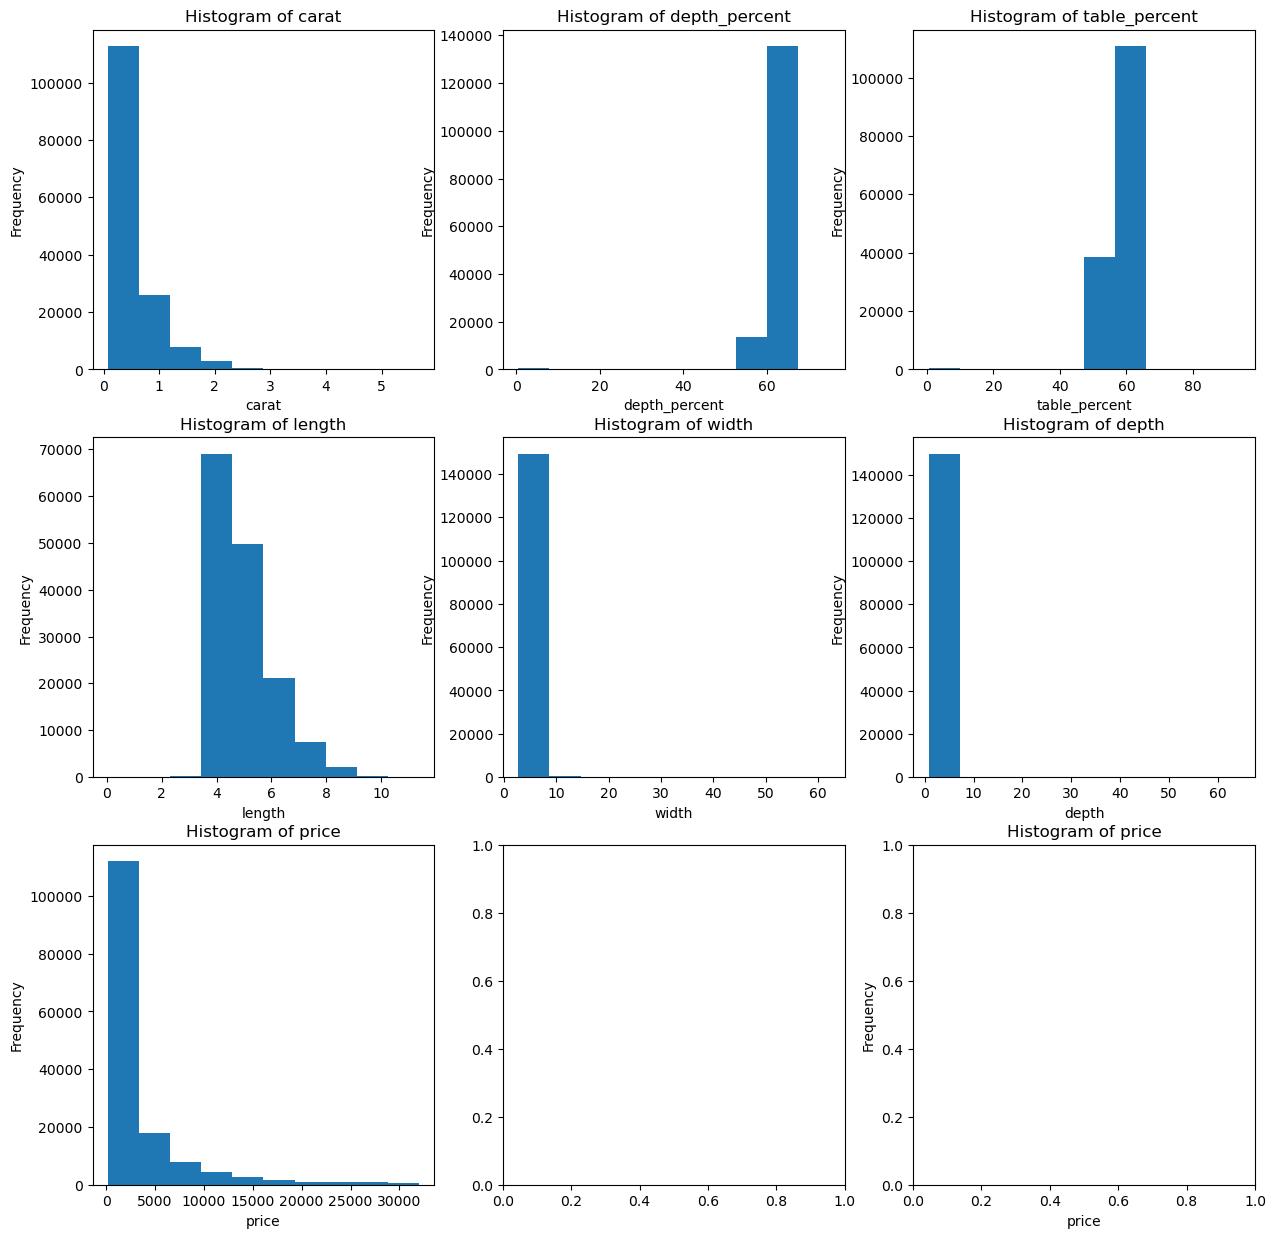

In [30]:
# plot the histogram of numerical features, put them in a grid of 3x3
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.ravel()

for i, feature in enumerate(numerical.columns):
    axes[i].hist(numerical[feature], bins=10)
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel("Frequency")
    axes[i].set_title(f"Histogram of {feature}")
    plt.xlabel(feature)
    plt.ylabel("Frequency")
    plt.title(f"Histogram of {feature}")

Question 1.2: How to deal with imbalance distribution?

For Categorical Feature Imbalance:
1. Resampling Methods:

- Oversampling: Create more instances of minority classes

    - Random oversampling: Duplicate minority class samples
    - SMOTE (Synthetic Minority Over-sampling Technique): Generate synthetic samples


- Undersampling: Reduce instances of majority classes

    - Random undersampling: Remove majority class samples
    - Tomek links: Remove majority samples close to minority samples



2. Class Weights:

- Assign higher weights to minority classes during model training
- Many algorithms accept a class_weight parameter (e.g., in scikit-learn)


For Numerical Feature Imbalance:
1. Binning/Discretization:

- Convert continuous variables to categorical bins
- Can help manage extreme values and imbalanced distributions

2. Transformation:

- Log, square root, or Box-Cox transformations for skewed distributions
- Normalizing or standardizing to bring all values to similar scales

/var/folders/ln/v3v0jnkn5250q18230nsptw00000gn/T/ipykernel_1879/1569284025.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numerical['carat'] = np.log(numerical['carat'])
/var/folders/ln/v3v0jnkn5250q18230nsptw00000gn/T/ipykernel_1879/1569284025.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numerical['length'] = np.log(numerical['length'])
/var/folders/ln/v3v0jnkn5250q18230nsptw00000gn/T/ipykernel_1879/1569284025.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

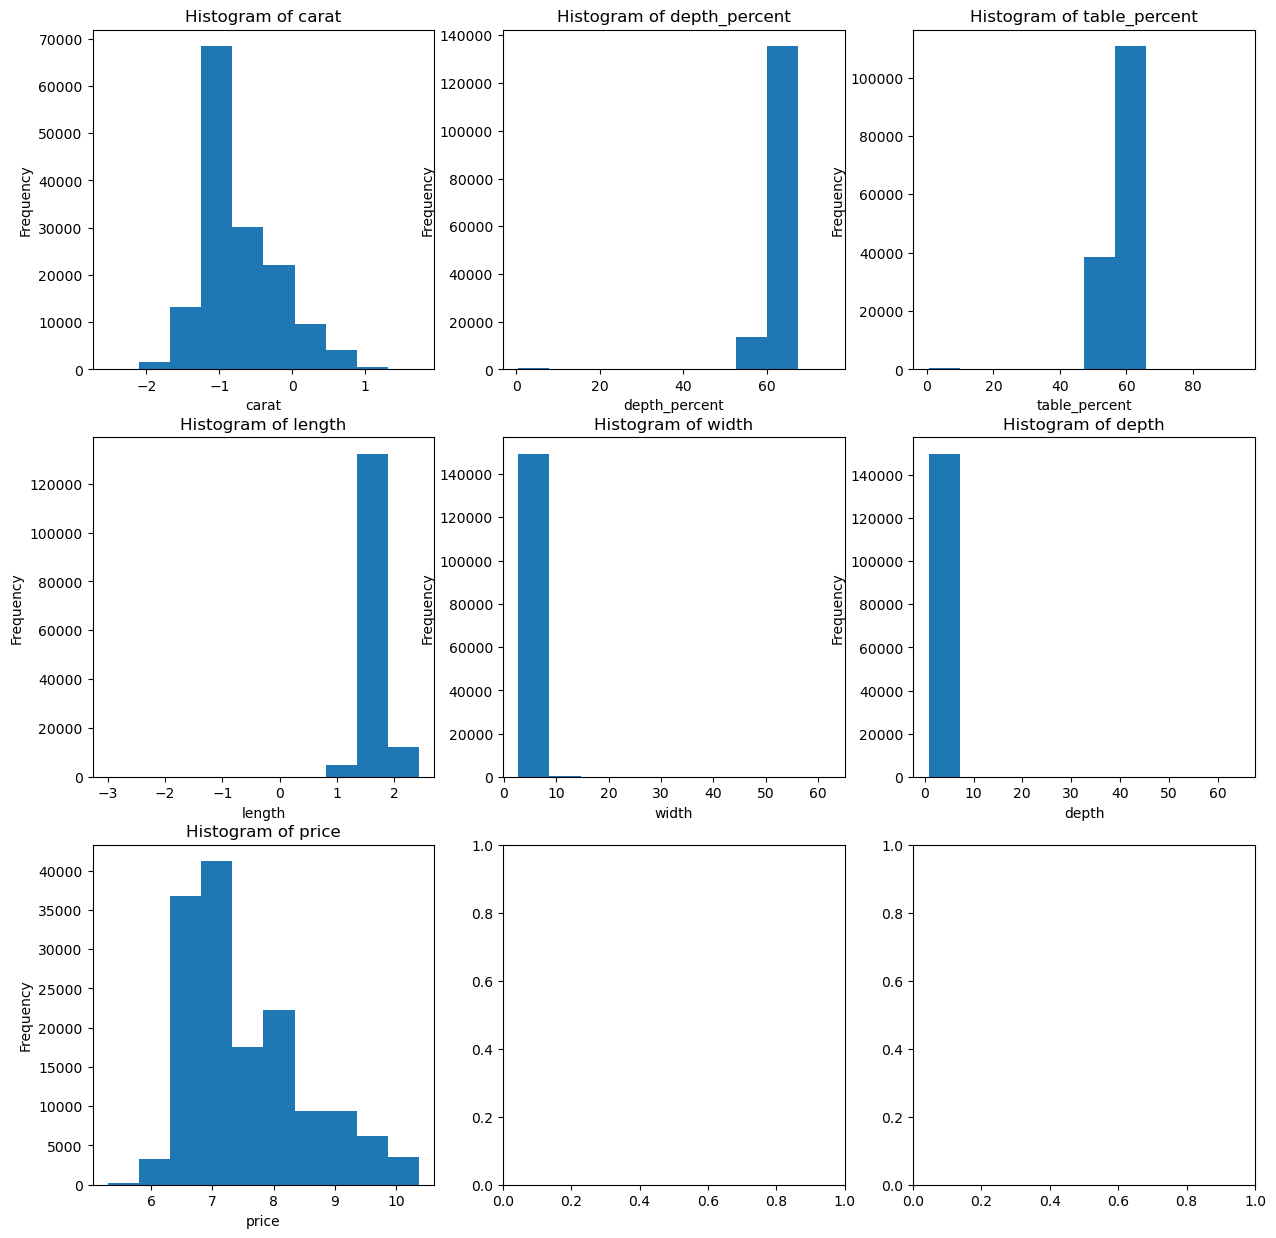

In [31]:
# apply log transformation to carat, length and price, which are right skewed
numerical['carat'] = np.log(numerical['carat'])
numerical['length'] = np.log(numerical['length'])
numerical['price'] = np.log(numerical['price'])

# plot the histogram of numerical features after log transformation, put them in a grid of 3x3
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.ravel()

for i, feature in enumerate(numerical.columns):
    axes[i].hist(numerical[feature], bins=10)
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel("Frequency")
    axes[i].set_title(f"Histogram of {feature}")



#### 1.2.2 Categorical Features
- box plot of categorical features vs target
- count of each categorical feature

##### Box Plot

A box plot for categorical features (where the x-axis shows categories and the y-axis shows a numerical value) tells you several important things about the distribution of a numerical variable across different categories:

1. Central tendency - The median (horizontal line inside the box) shows the middle value for each category

2. Spread and variability - The box itself shows the interquartile range (IQR), with:
- The bottom of the box representing the 25th percentile (Q1)
- The top of the box representing the 75th percentile (Q3)
- The whiskers typically extending to 1.5 × IQR, showing the range of typical values

3. Outliers - Points beyond the whiskers indicate potential outliers for each category

If you want to analyze the relationship between a feature and a target variable using box plots, you would:
- Put your categorical feature on the x-axis
- Put your numerical target variable on the y-axis
- This shows how your target variable's distribution changes across categories of your feature

<Figure size 640x480 with 0 Axes>

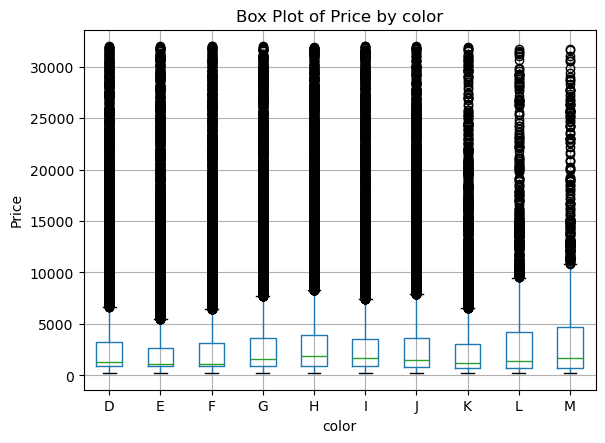

<Figure size 640x480 with 0 Axes>

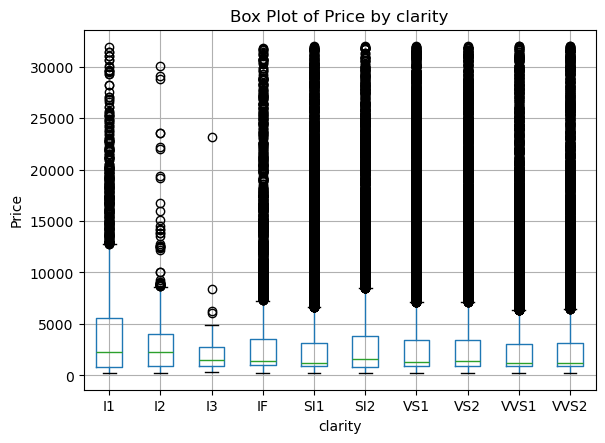

<Figure size 640x480 with 0 Axes>

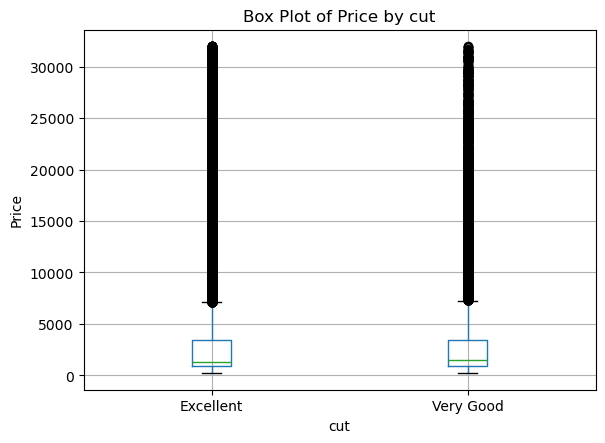

<Figure size 640x480 with 0 Axes>

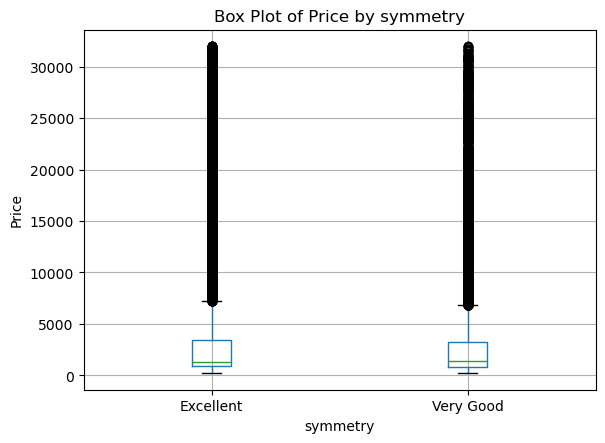

<Figure size 640x480 with 0 Axes>

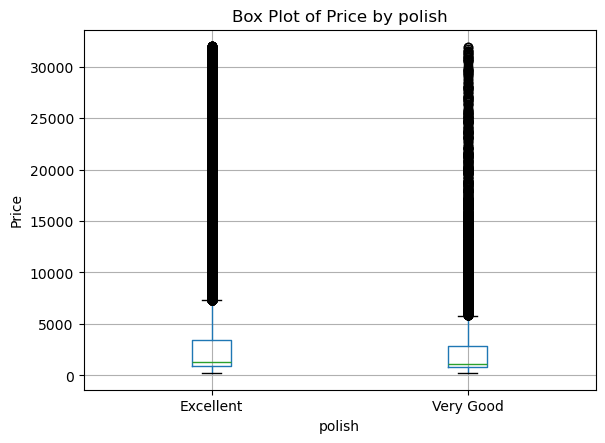

<Figure size 640x480 with 0 Axes>

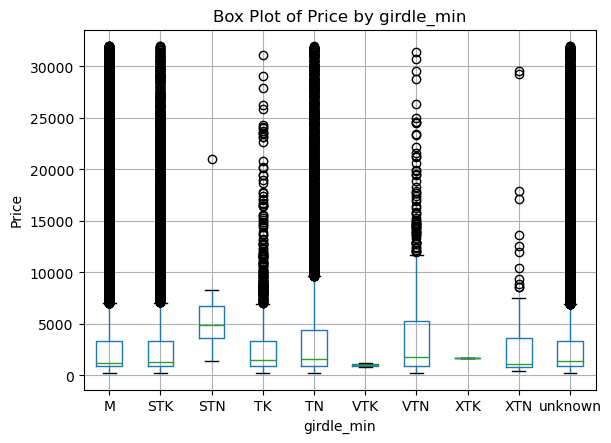

<Figure size 640x480 with 0 Axes>

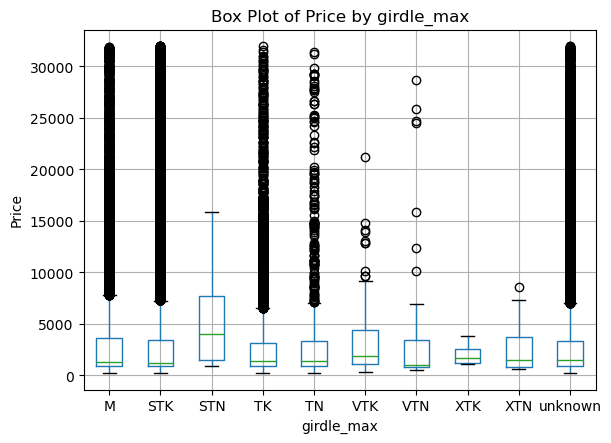

In [ ]:
# Create box plots for each categorical feature vs price
for cat_col in cat_vars:
    plt.figure()
    df.boxplot(column="price", by=cat_col)
    plt.title(f"Box Plot of Price by {cat_col}")
    plt.suptitle("")  # Remove default title
    plt.xlabel(cat_col)
    plt.ylabel("Price")
    plt.show()

Question 1.3

One key finding is that for each category, across all its possible values, there are numerous outliers. For instance, girdle_min consistently shows many outliers regardless of the specific girdle_min value. This suggests that these individual categorical features don’t reliably predict price on their own. For example, even if a diamond’s polish is rated “Excellent,” it doesn’t necessarily narrow the overall price range. That said, there are a few features and particular values that seem more closely tied to price. Specifically, for girdle_max, the “STN” and “XTK” categories, and for girdle_min, the “VTK” and “XTK” categories. In these cases, if a diamond falls under one of these categories—say, if it has an extra thick max girdle—its price tends to be lower, and there are fewer outliers in that group

##### Feature Count

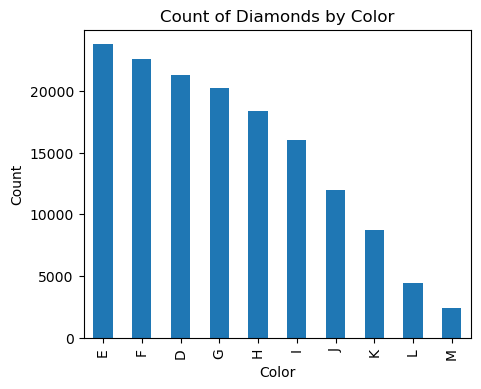

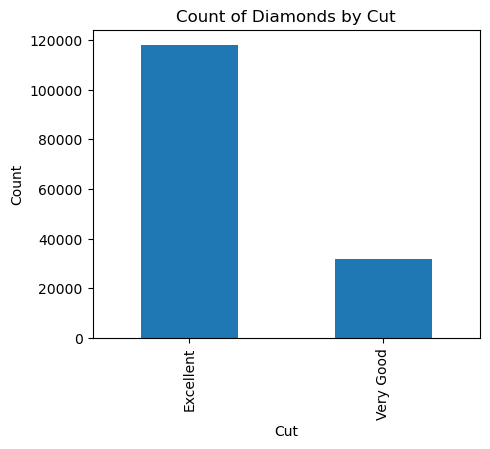

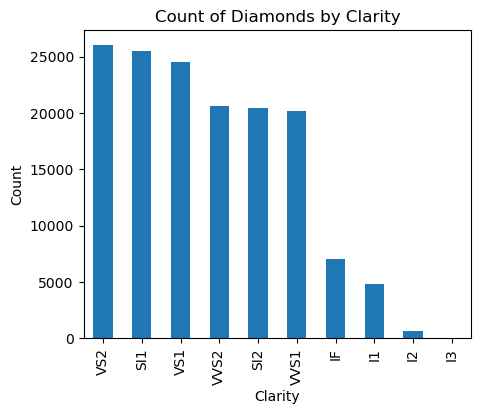

In [46]:
#plot the counts by color, cut and clarity, figure size 5x5
for var in ["color", "cut", "clarity"]:
    plt.figure(figsize=(5, 4))
    df[var].value_counts().plot(kind="bar")
    plt.title(f"Count of Diamonds by {var.capitalize()}")
    plt.xlabel(var.capitalize())
    plt.ylabel("Count")
    plt.show()

#### 1.2.3 Additional Feature Enginnering

 Question 2.1 Standardlization of Numerical Features

- Standardization (z-score normalization) transforms values to have mean=0 and standard deviation=1. 
- It should be applied only to numerical features, not to categorical features.
- It is beneficial for algorithms sensitive to feature scales (like linear/logistic regression, SVMs, k-means, neural networks) by preventing features with larger scales from dominating the model.
- It can improve convergence speed for gradient-based optimization.

In [57]:
# standardization on numerical features except for price
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numerical.drop("price", axis=1))

# transform the scaled data to a dataframe
numerical_scaled = pd.DataFrame(scaled_data, columns=numerical.drop("price", axis=1).columns)

# concate numerical_scaled and price
numerical_scaled = pd.concat([numerical_scaled, numerical["price"]], axis=1)


# print the shape of the scaled data
print(numerical_scaled.shape)

# print the mean and standard deviation of the scaled data
print(numerical_scaled.mean())
print(numerical_scaled.std()) 


(149871, 7)
carat           -2.002611e-16
depth_percent   -6.527401e-15
table_percent   -5.279610e-16
length           1.104470e-15
width           -3.155629e-16
depth           -1.213703e-16
price            7.529973e+00
dtype: float64
carat            1.000003
depth_percent    1.000003
table_percent    1.000003
length           1.000003
width            1.000003
depth            1.000003
price            0.966629
dtype: float64


### 1.3) Save Processed Dataset

In [53]:
# save the categorical_encoded, numerical_scaled and numerical dataframes to csv file
# save these files in "processed_data" folder
categorical_encoded.to_csv("processed_data/categorical_encoded.csv", index=False)
numerical_scaled.to_csv("processed_data/numerical_scaled.csv", index=False)
numerical.to_csv("processed_data/numerical.csv", index=False)

# concatenate categorical_encoded and numerical_scaled
df_processed = pd.concat([categorical_encoded, numerical_scaled], axis=1)
# save the concatenated dataframe to csv file
df_processed.to_csv("processed_data/df_processed.csv", index=False)



### 1.4) Feature Selection

Feature selection is crucial for building effective regression models. Here are the main approaches:
1. **Filter Methods**: evaluate features independently of the regression model
- Correlation Analysis: Select features with high correlation to the target but low correlation with each other;
- Variance Threshold: Remove features with low variance;
- Statistical Tests: F-tests, chi-squared tests, or ANOVA to identify significant features;

2. **Wrapper Methods**: evaluate subsets of features by training models
- Forward Selection: Start with no features and add them incrementally
- Backward Elimination: Start with all features and remove them incrementally
- Recursive Feature Elimination: Recursively eliminates features by importance
- Exhaustive Feature Selection: Tests all possible feature combinations (computationally expensive)

3. **Embedded Methods**: feature selection occurs during model training
- LASSO Regression: Uses L1 regularization to shrink some coefficients to zero
- Ridge Regression: Uses L2 regularization (doesn't eliminate features but reduces their impact)
- Elastic Net: Combines L1 and L2 regularization
- Decision Tree-based Methods: Feature importance from tree-based models like Random Forest



For our tutorial, we will experiment with 2 Filter Methods:
- mutual_info_regression, which computes the F-statistic and p-values for linear regression and assumes linear relationships.
- f_regression, which estimates mutual information using nearest neighbor methods and can detect both linear and non-linear relationships

In [9]:
# Load df_processed.csv
import pandas as pd

df_processed = pd.read_csv("processed_data/df_processed.csv")
df_processed.head()

,color,clarity,cut,polish,symmetry,girdle_min_M,girdle_min_STK,girdle_min_STN,girdle_min_TK,girdle_min_TN,...,girdle_max_XTK,girdle_max_XTN,girdle_max_unknown,carat,depth_percent,table_percent,length,width,depth,price
0,1,3,0,1,1,1,0,0,0,0,...,0,0,0,-2.922852,0.215866,0.345119,-2.950765,-2.078247,-0.730430,5.298317
1,1,3,1,1,1,0,1,0,0,0,...,0,0,0,-2.922852,0.014689,0.345119,-2.969701,-2.059209,-0.735681,5.298317
2,1,3,0,1,1,0,0,0,0,1,...,0,0,0,-2.922852,-0.186488,0.345119,-2.894354,-2.049690,-0.740932,5.298317
3,1,3,0,1,1,1,0,0,0,0,...,0,0,0,-2.922852,0.039836,0.345119,-2.931896,-2.068728,-0.735681,5.298317
4,1,3,1,0,1,0,1,0,0,0,...,0,0,0,-2.922852,0.769101,0.218693,-3.065392,-2.116324,-0.714676,5.298317


In [10]:
# Split the data into features (X) and target (y)
X = df_processed.drop("price", axis=1)
y = df_processed["price"]

In [11]:
# Perform mutual info regression
from sklearn.feature_selection import mutual_info_regression
# Calculate mutual information  
mutual_info = mutual_info_regression(X, y)

# Convert mutual information to a pandas Series and sort it
mutual_info_series = pd.Series(mutual_info, index=X.columns).sort_values(ascending=False)

# Get the top 2 features with the lowest mutual information
lowest_mi_features = mutual_info_series.tail(2)
print("Lowest MI Features:")
print(lowest_mi_features)


Lowest MI Features:
girdle_min_VTK    0.0
girdle_min_STN    0.0
dtype: float64


In [12]:
# Perform f_regression
from sklearn.feature_selection import f_regression
# f_regression returns two arrays: f_values and p_values, we only need the f_values
f_values, p_values = f_regression(X, y)

# Convert f_values to a pandas Series and sort it
f_regression_series = pd.Series(f_values, index=X.columns).sort_values(ascending=False)

# Get the top 2 features with the lowest f_regression scores
lowest_f_regression_features = f_regression_series.tail(2)
print("Lowest F-Regression Features:")
print(lowest_f_regression_features)

Lowest F-Regression Features:
girdle_min_XTN    0.003495
girdle_max_XTK    0.001731
dtype: float64


Question 2.2 Describe how feature selection affects the performance of your models in terms of test RMSE

Feature selection can significantly influence model performance by removing irrelevant or weakly correlated features, which can improve generalization and lowering test RMSE. 
With fewer features, classical models such as Linear Regression, Ridge, Lasso, and tree-based methods tend to train faster, produce simpler solutions, and become more interpretable, especially for linear models where each feature’s contribution can be readily understood. However, feature selection may not provide the same benefit for all model types. Deep neural networks, for instance, can inherently “ignore” less informative features by learning appropriate internal weights, particularly when large datasets are available. Similarly, models with built-in regularization (e.g., Lasso or Ridge) already penalize unimportant features, reducing the need for extensive manual feature selection. Nonetheless, most classical models stand to gain the most in terms of reduced overfitting and improved interpretability when strong feature selection techniques are applied.

# Part 2: Model Training

In [1]:
# Load df_processed.csv
import pandas as pd

df_processed = pd.read_csv("processed_data/df_processed.csv")
df_processed.head()

,color,clarity,cut,polish,symmetry,girdle_min_M,girdle_min_STK,girdle_min_STN,girdle_min_TK,girdle_min_TN,...,girdle_max_XTK,girdle_max_XTN,girdle_max_unknown,carat,depth_percent,table_percent,length,width,depth,price
0,1,3,0,1,1,1,0,0,0,0,...,0,0,0,-2.922852,0.215866,0.345119,-2.950765,-2.078247,-0.730430,5.298317
1,1,3,1,1,1,0,1,0,0,0,...,0,0,0,-2.922852,0.014689,0.345119,-2.969701,-2.059209,-0.735681,5.298317
2,1,3,0,1,1,0,0,0,0,1,...,0,0,0,-2.922852,-0.186488,0.345119,-2.894354,-2.049690,-0.740932,5.298317
3,1,3,0,1,1,1,0,0,0,0,...,0,0,0,-2.922852,0.039836,0.345119,-2.931896,-2.068728,-0.735681,5.298317
4,1,3,1,0,1,0,1,0,0,0,...,0,0,0,-2.922852,0.769101,0.218693,-3.065392,-2.116324,-0.714676,5.298317


In [2]:
# Split the data into features (X) and target (y)
X = df_processed.drop("price", axis=1)
y = df_processed["price"]

## Linear Regression

**Linear regression** models the relationship between variables by fitting a linear equation to observed data. 

The simplest form is:

y = β₀ + β₁x₁ + β₂x₂ + ... + βₙxₙ + ε

Where:

- y is the dependent variable
- x₁, x₂, ..., xₙ are independent variables
- β₀, β₁, ..., βₙ are coefficients (parameters)
- ε is the error term

The model estimates coefficients by minimizing the sum of squared differences between observed and predicted values (ordinary least squares). Linear regression works well when the data has a linear pattern, variables are independent, and there's low multicollinearity.



**Ridge Regression** (L2 Regularization)

Ridge regression adds a penalty term to the linear regression cost function:

Cost = Sum of squared residuals + λ × Sum of squared coefficients

The λ (lambda) parameter controls the strength of regularization. 

Ridge regression reduces model complexity by shrinking coefficients toward zero and works well when many features have moderate impacts on the outcome.

**Lasso Regression** (L1 Regularization)
Lasso (Least Absolute Shrinkage and Selection Operator) uses a different penalty term:

Cost = Sum of squared residuals + λ × Sum of absolute coefficients

Lasso performs feature selection by setting some coefficients exactly to zero(sparse solution).
It works well when you have many features with only a few being truly relevant and helps with interpretability by producing simpler models

In [197]:
#Set up cross validation
X = df_scaled[top_4_features.index]
X_with_constant = sm.add_constant(X)

kf = KFold(n_splits=10, shuffle=True, random_state=42)
rmse_scores = []
coef_name_list = {i: name for i, name in enumerate(X_with_constant.columns)}
learned_params_list = {param: 0 for param in X_with_constant.columns}

# Perform K-Fold Cross-Validation
for train_index, test_index in kf.split(X_with_constant):
    X_train, X_test = X_with_constant.iloc[train_index], X_with_constant.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model = sm.OLS(y_train, X_train).fit()
    y_pred = model.predict(X_test)

    for param_name, param_val in model.params.items():
      learned_params_list[param_name] += param_val


    rmse = mean_squared_error(y_test, y_pred, squared=False)
    rmse_scores.append(rmse)

mean_rmse = np.mean(rmse_scores)

learned_params_list = {name: val / 10 for name, val in learned_params_list.items()}

model_summary = model.summary()

p_values = model.pvalues

print(f"10-Fold RMSE Scores using OLS: {rmse_scores}")
print(f"Average RMSE using OLS: {mean_rmse:.4f}")
print (f"Average learned params using OLS: {learned_params_list}")
print(model_summary)
print("P-values for each feature:")
print(p_values)

10-Fold RMSE Scores using OLS: [0.4043157042400082, 0.3967329714537551, 0.3903819983109775, 0.3968734554954966, 0.4058401423189544, 0.4165553623833152, 0.38815315072520445, 0.3943007893408355, 0.39862713718348675, 0.4018437522538925]
Average RMSE using OLS: 0.3994
Average learned params using OLS: {'const': -5.964108231760373e-07, 'carat': 1.2349717625804462, 'width': -0.010829934689760085, 'length': -0.31901115922901013, 'depth': -0.003657729897435644}
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.841
Model:                            OLS   Adj. R-squared:                  0.841
Method:                 Least Squares   F-statistic:                 1.778e+05
Date:                Sat, 08 Mar 2025   Prob (F-statistic):               0.00
Time:                        20:42:40   Log-Likelihood:                -67488.
No. Observations:              134884   AIC:                        

/Users/zth/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/zth/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/zth/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/zth/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To

### Lasso Regression

In [8]:
from sklearn.linear_model import LassoCV

# Define a range of alpha values
alphas = np.logspace(-2, 2, 100)

# Initialize Lasso with automatic alpha selection
lasso_cv = LassoCV(alphas=alphas, cv=10)
lasso_cv.fit(X, y)

# Best alpha found
best_alpha = lasso_cv.alpha_
print(f"Optimal alpha for Lasso: {best_alpha:.4f}")


Optimal alpha for Lasso: 0.0100


In [178]:
#Set up cross validation
X = df_scaled[top_4_features.index]
X_with_constant = sm.add_constant(X)

kf = KFold(n_splits=10, shuffle=True, random_state=42)
rmse_scores = []
coef_name_list = {i: name for i, name in enumerate(X_with_constant.columns)}
learned_params_list = {param: 0 for param in X_with_constant.columns}

# Perform K-Fold Cross-Validation
for train_index, test_index in kf.split(X_with_constant):
    X_train, X_test = X_with_constant.iloc[train_index], X_with_constant.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model = Lasso(alpha=best_alpha)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    for i, param_val in enumerate(model.coef_):
      param_name = coef_name_list[i]
      learned_params_list[param_name] += param_val


    rmse = mean_squared_error(y_test, y_pred, squared=False)
    rmse_scores.append(rmse)

mean_rmse = np.mean(rmse_scores)

learned_params_list = {name: val / 10 for name, val in learned_params_list.items()}

print(f"10-Fold RMSE Scores using Lasso: {rmse_scores}")
print(f"Average RMSE using Lasso: {mean_rmse:.4f}")
print (f"Average learned params using Lasso: {learned_params_list}")

/Users/zth/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/zth/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/zth/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/zth/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To

10-Fold RMSE Scores using Lasso: [0.41096875171912445, 0.404556113179265, 0.39762096241272443, 0.40537309829155166, 0.4170268495159163, 0.41986032716778365, 0.3942322425399875, 0.4044817669830297, 0.40508899741064136, 0.4104807423284689]
Average RMSE using Lasso: 0.4070
Average learned params using Lasso: {'const': 0.0, 'carat': 0.9034789004138254, 'width': 0.0, 'length': 0.0, 'depth': 0.0}


/Users/zth/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### Ridge regression

In [14]:
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

alphas = [0.01, 0.1, 1, 5, 10]
best_alpha = None
best_score = 0
for alpha in alphas:
  ridge = Ridge(alpha=alpha)
  ridge.fit(X_train, y_train)
  test_score = ridge.score(X_test, y_test)
  if test_score > best_score:
    best_score = test_score
    best_alpha = alpha

print (f"Optimal alpha for Lasso: {best_alpha}")

Optimal alpha for Lasso: 1


In [ ]:
#Set up cross validation
X = df_scaled.drop("price", axis=1)
y = df_scaled["price"]
X = df_scaled[top_4_features.index]
X_with_constant = sm.add_constant(X)

kf = KFold(n_splits=10, shuffle=True, random_state=42)
rmse_scores = []
coef_name_list = {i: name for i, name in enumerate(X_with_constant.columns)}
learned_params_list = {param: 0 for param in X_with_constant.columns}
r_sqrt = []

# Perform K-Fold Cross-Validation
for train_index, test_index in kf.split(X_with_constant):
    X_train, X_test = X_with_constant.iloc[train_index], X_with_constant.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model = Ridge(alpha=best_alpha)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    for i, param_val in enumerate(model.coef_):
      param_name = coef_name_list[i]
      learned_params_list[param_name] += param_val


    rmse = mean_squared_error(y_test, y_pred, squared=False)
    rmse_scores.append(rmse)

    r_s = r2_score(y_test, y_pred)
    r_sqrt.append(r_s)

mean_rmse = np.mean(rmse_scores)

learned_params_list = {name: val / 10 for name, val in learned_params_list.items()}

mean_r_sqrt_score = np.mean(r_sqrt)

print(f"10-Fold RMSE Scores using Ridge: {rmse_scores}")
print(f"Average RMSE using Ridge: {mean_rmse:.4f}")
print (f"Average learned params using Ridge: {learned_params_list}")
print (f"Average r-square score using Ridge: {mean_r_sqrt_score}")

10-Fold RMSE Scores using Ridge: [0.40431511371565226, 0.3967317501616707, 0.39038006378551526, 0.396876834622035, 0.4058556757353388, 0.41653954700293044, 0.3881491994262577, 0.39431125013436896, 0.39862262407757815, 0.4018448233110748]
Average RMSE using Ridge: 0.3994
Average learned params using Ridge: {'const': 0.0, 'carat': 1.233941898168466, 'width': -0.010986005884823305, 'length': -0.31784498563998964, 'depth': -0.0036647970729948207}
Average r2 score using Ridge: 0.8404217331538921


/Users/zth/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/zth/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/zth/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/zth/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To

### Compare with no standardization

In [192]:
X_unscaled = df_processed.drop("price", axis=1)
y_unscaled = df_processed["price"]

X_unscaled_used = X_unscaled[top_4_features.index]

In [193]:
from sklearn.linear_model import RidgeCV

X_unscaled_used = X_unscaled_used.values
y_unscaled = y_unscaled.values

X_train, X_test, y_train, y_test = train_test_split(X_unscaled_used, y_unscaled, test_size=0.2, random_state=42)

alphas = [0.01, 0.1, 1, 5, 10]
best_alpha = None
best_score = 0
for alpha in alphas:
  ridge = Ridge(alpha=alpha)
  ridge.fit(X_train, y_train)
  test_score = ridge.score(X_test, y_test)
  if test_score > best_score:
    best_score = test_score
    best_alpha = alpha

print (f"Optimal alpha for Lasso: {best_alpha}")

Optimal alpha for Lasso: 5


In [194]:
#Set up cross validation
X = df_processed.drop("price", axis=1)
y = df_processed["price"]
X = df_processed[top_4_features.index]
X_with_constant = sm.add_constant(X)

kf = KFold(n_splits=10, shuffle=True, random_state=42)
rmse_scores = []
coef_name_list = {i: name for i, name in enumerate(X_with_constant.columns)}
learned_params_list = {param: 0 for param in X_with_constant.columns}

# Perform K-Fold Cross-Validation
for train_index, test_index in kf.split(X_with_constant):
    X_train, X_test = X_with_constant.iloc[train_index], X_with_constant.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model = Ridge(alpha=best_alpha)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    for i, param_val in enumerate(model.coef_):
      param_name = coef_name_list[i]
      learned_params_list[param_name] += param_val


    rmse = mean_squared_error(y_test, y_pred, squared=False)
    rmse_scores.append(rmse)

    r_s = r2_score(y_test, y_pred)
    r_sqrt.append(r_s)


mean_rmse = np.mean(rmse_scores)

learned_params_list = {name: val / 10 for name, val in learned_params_list.items()}

mean_r_sqrt_score = np.mean(r_sqrt)

print(f"10-Fold RMSE Scores using Ridge without standardization: {rmse_scores}")
print(f"Average RMSE using Ridge without standardization: {mean_rmse:.4f}")
print (f"Average learned params using Ridge without standardization: {learned_params_list}")
print(f"Average r-squre score using Ridge without standardization: {mean_r_sqrt_score}")

10-Fold RMSE Scores using Ridge without standardization: [1904.0499124731402, 1868.3481819098279, 1838.4080796708547, 1869.1159257488118, 1911.6215411159887, 1961.3385245603367, 1827.7934479751607, 1857.170304482116, 1877.1883828926304, 1892.4914006897536]
Average RMSE using Ridge without standardization: 1880.7526
Average learned params using Ridge without standardization: {'const': 0.0, 'carat': 14443.155794613293, 'width': -48.84898558859773, 'length': -1462.5154232747147, 'depth': -9.089669986315906}
Average r-squre score using Ridge without standardization: 0.8404212730362737


/Users/zth/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/zth/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/zth/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/zth/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To

## Polynomial Regression

In [7]:
# Load processed_data
import pandas as pd
from sklearn.model_selection import train_test_split

df_processed = pd.read_csv("processed_data/df_processed.csv")
# df_processed.head()

# Split the data into features (X) and target (y)
X = df_processed.drop("price", axis=1)
y = df_processed["price"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
# Perform feature selection through mutual info regression on training data
from sklearn.feature_selection import mutual_info_regression

# Calculate mutual information
mutual_info = mutual_info_regression(X_train, y_train)

# Convert mutual information to a pandas Series and sort it
mutual_info_series = pd.Series(mutual_info, index=X.columns).sort_values(ascending=False)


In [11]:
# Get the top 4 features with the highest mutual information
top_4_features = mutual_info_series.head(4)
print("Top 4 Features:")
print(top_4_features)

# extract the top 4 features
X_train_top_4 = X_train[top_4_features.index]
X_test_top_4 = X_test[top_4_features.index]

Top 4 Features:
carat     1.359188
width     1.192835
length    1.185174
depth     1.149734
dtype: float64


In [13]:
# Use grid search to find the best polynomial degree, use ridge regression with default alpha
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.metrics import root_mean_squared_error

# Define the pipeline
pipeline = Pipeline([
    ('poly', PolynomialFeatures()),
    ('ridge', Ridge())
])
# Define the parameter grid
param_grid = {
    'poly__degree': [1, 2, 3, 4, 5, 6],
    'ridge__alpha': [0.1, 1, 10]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=10, scoring='neg_root_mean_squared_error',verbose=0)

# Fit the model with extracted features
grid_search.fit(X_train_top_4, y_train)

/opt/anaconda3/envs/ece219/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=1.38456e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/anaconda3/envs/ece219/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=1.44415e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/anaconda3/envs/ece219/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=1.4202e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/anaconda3/envs/ece219/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=1.43319e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/anaconda3/envs/ece21

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('poly', PolynomialFeatures()),
                                       ('ridge', Ridge())]),
             param_grid={'poly__degree': [1, 2, 3, 4, 5, 6],
                         'ridge__alpha': [0.1, 1, 10]},
             scoring='neg_root_mean_squared_error')

In [15]:
# Get the best parameters
best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")

# Get the best model
best_model = grid_search.best_estimator_

# Predict on the test set
y_pred = best_model.predict(X_test_top_4)

# Calculate RMSE
rmse = root_mean_squared_error(y_test, y_pred)
print(f"RMSE on Test Set: {rmse:.4f}")

Best Parameters: {'poly__degree': 1, 'ridge__alpha': 0.1}
RMSE on Test Set: 0.3172


In [22]:
# what are the most salient feaetures?
# Get the coefficients of the best model
import numpy as np 

coefficients = best_model.named_steps['ridge'].coef_[1:]  # Exclude the intercept

# Sort the coefficients and get the feature names
sorted_indices = np.argsort(np.abs(coefficients))[::-1]
feature_names = X_train_top_4.columns[sorted_indices]

# Print the most salient features
print("Most Salient Features:")
for i in sorted_indices:
    print(f"{feature_names[i]}: {coefficients[i]:.4f}")

Most Salient Features:
carat: 0.6579
width: 0.1782
length: 0.0796
depth: 0.0046


## Neural Network

## Random Forest

## LightGBM, CatBoost and Bayesian Optimization